In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/FIX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,12.51,12.68,12.24,12.45,11.569341,263100
1,1/3/2013,12.50,12.62,12.42,12.55,11.662267,73500
2,1/4/2013,12.66,12.96,12.59,12.78,11.875998,102600
3,1/7/2013,12.69,12.70,12.59,12.66,11.764485,39600
4,1/8/2013,12.64,12.77,12.46,12.54,11.652973,32500


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 678.160001.3, cost: -32733.916016, total money: 10180.250005
epoch: 20, total rewards: 1653.790012.3, cost: -30744.958984, total money: 8537.350009
epoch: 30, total rewards: 934.560003.3, cost: -32517.875000, total money: 9807.460013
epoch: 40, total rewards: 1134.890012.3, cost: -32231.123047, total money: 9754.790013
epoch: 50, total rewards: 1341.379999.3, cost: -32046.046875, total money: 9760.310003
epoch: 60, total rewards: 611.940006.3, cost: -33152.605469, total money: 9501.040012
epoch: 70, total rewards: 1086.000020.3, cost: -32525.300781, total money: 9066.000016
epoch: 80, total rewards: 789.490005.3, cost: -33872.355469, total money: 10538.630004
epoch: 90, total rewards: 755.500021.3, cost: -33575.742188, total money: 10013.750021
epoch: 100, total rewards: 823.080033.3, cost: -33036.171875, total money: 9319.590039
epoch: 110, total rewards: 1108.820028.3, cost: -32621.710938, total money: 8951.370031
epoch: 120, total rewards: 963.780035.3, cos

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 12.450000, total balance 9987.550000
day 1, sell 1 unit at price 12.550000, investment 0.803216 %, total balance 10000.100000,
day 3: buy 1 unit at price 12.660000, total balance 9987.440001
day 4: buy 1 unit at price 12.540000, total balance 9974.900001
day 6: buy 1 unit at price 12.680000, total balance 9962.220000
day 7: buy 1 unit at price 12.590000, total balance 9949.630000
day 8, sell 1 unit at price 12.650000, investment -0.078991 %, total balance 9962.280000,
day 11, sell 1 unit at price 12.490000, investment -0.398726 %, total balance 9974.770000,
day 14: buy 1 unit at price 12.860000, total balance 9961.910000
day 16, sell 1 unit at price 12.810000, investment 1.025237 %, total balance 9974.720000,
day 17: buy 1 unit at price 12.930000, total balance 9961.790000
day 18: buy 1 unit at price 12.980000, total balance 9948.810000
day 19: buy 1 unit at price 12.640000, total balance 9936.170000
day 20, sell 1 unit at price 12.910000, investment 2.541697

day 319: buy 1 unit at price 15.400000, total balance 9681.000002
day 320, sell 1 unit at price 15.030000, investment -17.144431 %, total balance 9696.030002,
day 321: buy 1 unit at price 14.790000, total balance 9681.240002
day 322: buy 1 unit at price 14.730000, total balance 9666.510002
day 326, sell 1 unit at price 15.440000, investment -11.619919 %, total balance 9681.950002,
day 327: buy 1 unit at price 15.840000, total balance 9666.110002
day 328, sell 1 unit at price 15.720000, investment -3.261537 %, total balance 9681.830002,
day 331: buy 1 unit at price 15.120000, total balance 9666.710002
day 332: buy 1 unit at price 14.980000, total balance 9651.730002
day 334, sell 1 unit at price 14.910000, investment -10.180726 %, total balance 9666.640002,
day 337: buy 1 unit at price 15.300000, total balance 9651.340002
day 338: buy 1 unit at price 15.390000, total balance 9635.950002
day 339, sell 1 unit at price 15.010000, investment -3.534705 %, total balance 9650.960002,
day 340, 

day 498: buy 1 unit at price 17.120001, total balance 9642.390007
day 500, sell 1 unit at price 17.420000, investment 29.132694 %, total balance 9659.810007,
day 502: buy 1 unit at price 17.299999, total balance 9642.510008
day 503: buy 1 unit at price 17.120001, total balance 9625.390007
day 504, sell 1 unit at price 16.879999, investment 27.588811 %, total balance 9642.270006,
day 505: buy 1 unit at price 16.600000, total balance 9625.670006
day 507: buy 1 unit at price 16.440001, total balance 9609.230005
day 509: buy 1 unit at price 16.620001, total balance 9592.610004
day 510: buy 1 unit at price 16.790001, total balance 9575.820003
day 511, sell 1 unit at price 16.840000, investment 29.738064 %, total balance 9592.660004,
day 512, sell 1 unit at price 16.780001, investment 28.385624 %, total balance 9609.440004,
day 514: buy 1 unit at price 16.209999, total balance 9593.230005
day 516, sell 1 unit at price 15.870000, investment 23.887583 %, total balance 9609.100005,
day 518, sel

day 674: buy 1 unit at price 28.020000, total balance 9563.340005
day 676: buy 1 unit at price 28.490000, total balance 9534.850005
day 678, sell 1 unit at price 28.410000, investment 24.332601 %, total balance 9563.260005,
day 679, sell 1 unit at price 28.740000, investment 24.093264 %, total balance 9592.000005,
day 683, sell 1 unit at price 28.440001, investment 24.736849 %, total balance 9620.440005,
day 684: buy 1 unit at price 28.700001, total balance 9591.740005
day 685: buy 1 unit at price 28.000000, total balance 9563.740005
day 686, sell 1 unit at price 27.830000, investment 21.316475 %, total balance 9591.570004,
day 687, sell 1 unit at price 27.209999, investment 18.047722 %, total balance 9618.780004,
day 692: buy 1 unit at price 27.469999, total balance 9591.310004
day 693, sell 1 unit at price 27.650000, investment 21.913577 %, total balance 9618.960004,
day 694, sell 1 unit at price 28.230000, investment 20.641026 %, total balance 9647.190003,
day 695, sell 1 unit at pr

day 844, sell 1 unit at price 31.440001, investment 27.442239 %, total balance 9655.360003,
day 845, sell 1 unit at price 31.080000, investment 21.548691 %, total balance 9686.440003,
day 846: buy 1 unit at price 31.240000, total balance 9655.200004
day 848: buy 1 unit at price 31.010000, total balance 9624.190003
day 850: buy 1 unit at price 30.480000, total balance 9593.710004
day 851, sell 1 unit at price 30.010000, investment 14.541982 %, total balance 9623.720004,
day 852, sell 1 unit at price 31.090000, investment 9.202673 %, total balance 9654.810004,
day 853, sell 1 unit at price 31.000000, investment 10.516937 %, total balance 9685.810004,
day 858: buy 1 unit at price 32.000000, total balance 9653.810004
day 860, sell 1 unit at price 32.139999, investment 9.468660 %, total balance 9685.950004,
day 861, sell 1 unit at price 32.200001, investment 9.523814 %, total balance 9718.150004,
day 862, sell 1 unit at price 32.220001, investment 11.526486 %, total balance 9750.370006,
day

day 1013, sell 1 unit at price 32.500000, investment 0.619197 %, total balance 9932.280009,
day 1014: buy 1 unit at price 32.950001, total balance 9899.330009
day 1016, sell 1 unit at price 33.799999, investment 5.624998 %, total balance 9933.130008,
day 1020, sell 1 unit at price 33.250000, investment -1.188712 %, total balance 9966.380008,
day 1021: buy 1 unit at price 32.849998, total balance 9933.530009
day 1022: buy 1 unit at price 33.700001, total balance 9899.830009
day 1023: buy 1 unit at price 34.049999, total balance 9865.780009
day 1024: buy 1 unit at price 34.049999, total balance 9831.730010
day 1027: buy 1 unit at price 33.849998, total balance 9797.880012
day 1028, sell 1 unit at price 33.750000, investment 2.272727 %, total balance 9831.630012,
day 1029, sell 1 unit at price 33.700001, investment 1.506024 %, total balance 9865.330012,
day 1031: buy 1 unit at price 33.549999, total balance 9831.780013
day 1032: buy 1 unit at price 33.650002, total balance 9798.130012
day

day 1323: buy 1 unit at price 41.500000, total balance 9672.680015
day 1324: buy 1 unit at price 40.500000, total balance 9632.180015
day 1325, sell 1 unit at price 40.150002, investment -4.970411 %, total balance 9672.330016,
day 1326: buy 1 unit at price 40.950001, total balance 9631.380015
day 1327, sell 1 unit at price 40.950001, investment -3.076921 %, total balance 9672.330016,
day 1330, sell 1 unit at price 41.650002, investment -4.691074 %, total balance 9713.980018,
day 1331: buy 1 unit at price 41.650002, total balance 9672.330016
day 1333, sell 1 unit at price 42.150002, investment -2.655884 %, total balance 9714.480018,
day 1334, sell 1 unit at price 41.750000, investment -4.680364 %, total balance 9756.230018,
day 1337: buy 1 unit at price 41.650002, total balance 9714.580016
day 1338: buy 1 unit at price 41.549999, total balance 9673.030017
day 1339, sell 1 unit at price 43.750000, investment 2.699534 %, total balance 9716.780017,
day 1340, sell 1 unit at price 42.200001,

day 1480, sell 1 unit at price 56.110001, investment 1.464740 %, total balance 10364.600024,
day 1482, sell 1 unit at price 53.689999, investment -2.239621 %, total balance 10418.290023,
day 1483, sell 1 unit at price 52.560001, investment -2.648639 %, total balance 10470.850024,
day 1486, sell 1 unit at price 52.270000, investment 0.674118 %, total balance 10523.120025,
day 1487: buy 1 unit at price 51.419998, total balance 10471.700027
day 1489, sell 1 unit at price 52.049999, investment -2.655698 %, total balance 10523.750026,
day 1490: buy 1 unit at price 52.660000, total balance 10471.090026
day 1492: buy 1 unit at price 48.299999, total balance 10422.790027
day 1494: buy 1 unit at price 46.520000, total balance 10376.270026
day 1495, sell 1 unit at price 46.230000, investment -15.034002 %, total balance 10422.500026,
day 1496, sell 1 unit at price 46.799999, investment -17.299878 %, total balance 10469.300025,
day 1497, sell 1 unit at price 46.860001, investment -20.170358 %, tot

day 1673: buy 1 unit at price 37.049999, total balance 10443.350032
day 1676, sell 1 unit at price 38.049999, investment -11.035775 %, total balance 10481.400031,
day 1679, sell 1 unit at price 37.389999, investment -8.671225 %, total balance 10518.790031,
day 1680, sell 1 unit at price 38.389999, investment -7.090998 %, total balance 10557.180030,
day 1683: buy 1 unit at price 41.029999, total balance 10516.150031
day 1684, sell 1 unit at price 41.869999, investment 7.029653 %, total balance 10558.020030,
day 1685, sell 1 unit at price 40.410000, investment 5.206977 %, total balance 10598.430030,
day 1689, sell 1 unit at price 42.509998, investment 12.460315 %, total balance 10640.940028,
day 1690: buy 1 unit at price 43.049999, total balance 10597.890029
day 1691: buy 1 unit at price 42.630001, total balance 10555.260028
day 1692, sell 1 unit at price 42.930000, investment 15.870449 %, total balance 10598.190028,
day 1696: buy 1 unit at price 44.169998, total balance 10554.020030
day

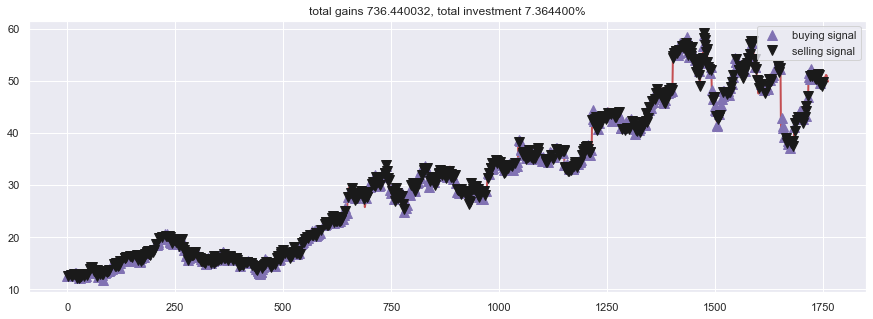

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()